# Similarity-Driven Clustering of Candidates Populating the Final Populations
First, we collect all the data from all evolutionary experiments. Note that we exclude `run_1.0` because that run was interrupted very early and its best candidates were used as initial population in `run_1.1`.

Therefore **`run_1.0` is not included in this analysis**.

In [1]:
import glob
from rdkit import Chem, DataStructs

from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')

totFitFiles=0
allCandidates=[]
unqCandidates=[]
unqCandidatesWFitness=[]
unqFitnesses=[]
unqPathNames=[]
unqUIDs=[]
for fitFile in glob.glob("../run_*/Final*/*_FIT.sdf"):
    if 'run_1.0' in fitFile:
        print('excluding ',fitFile)
        continue
    totFitFiles=totFitFiles+1;
    supplier = Chem.SDMolSupplier(fitFile);
    i=0
    for mol in supplier:
        i=i+1;
        mol.SetProp('Pathname',fitFile)
        allCandidates.append(mol)
        inchi = Chem.inchi.MolToInchi(mol)
        inchikey = Chem.inchi.InchiToInchiKey(inchi)
        if inchikey == '':
            print ('ERROR! Empty InChIKey.');
            break;
        if not inchikey in unqUIDs:
            unqCandidates.append(mol)
            unqUIDs.append(inchikey)
            if mol.HasProp('FITNESS'):
                unqCandidatesWFitness.append(mol)
                unqFitnesses.append(float(mol.GetProp('FITNESS')))
                unqPathNames.append(fitFile)
    if i > 1:
        print ('ERROR! One SDF file is expected to contain only one molecule!');
        break;
    
print('Total imported FIT files:      ',totFitFiles);
print('Total candidates:              ',len(allCandidates));
print('Unique UID:                    ',len(unqCandidates));
print('Unique UIDs with fitness:      ',len(unqCandidatesWFitness));


excluding  ../run_1.0/Final/M00000009_FIT.sdf
excluding  ../run_1.0/Final/M00000026_FIT.sdf
excluding  ../run_1.0/Final/M00000036_FIT.sdf
excluding  ../run_1.0/Final/M00000001_FIT.sdf
excluding  ../run_1.0/Final/M00000008_FIT.sdf
excluding  ../run_1.0/Final/M00000018_FIT.sdf
excluding  ../run_1.0/Final/M00000037_FIT.sdf
excluding  ../run_1.0/Final/M00000027_FIT.sdf
excluding  ../run_1.0/Final/M00000013_FIT.sdf
excluding  ../run_1.0/Final/M00000035_FIT.sdf
excluding  ../run_1.0/Final/M00000012_FIT.sdf
excluding  ../run_1.0/Final/M00000038_FIT.sdf
excluding  ../run_1.0/Final/M00000028_FIT.sdf
excluding  ../run_1.0/Final/M00000007_FIT.sdf
excluding  ../run_1.0/Final/M00000017_FIT.sdf
excluding  ../run_1.0/Final/M00000021_FIT.sdf
excluding  ../run_1.0/Final/M00000031_FIT.sdf
excluding  ../run_1.0/Final/M00000030_FIT.sdf
excluding  ../run_1.0/Final/M00000029_FIT.sdf
excluding  ../run_1.0/Final/M00000032_FIT.sdf
excluding  ../run_1.0/Final/M00000040_FIT.sdf
excluding  ../run_1.0/Final/M00000

Then we purge the worst ones, i.e., we keep only the best N candidates

In [2]:
# keep best N
headSize = 150

candidatesUnderAnalysis=[]
fitnesses=[]

i = 0
for fitness,pathName in sorted(zip(unqFitnesses,unqPathNames),reverse=True):
    i = i+1
    if i > headSize:
        break
    supplier = Chem.SDMolSupplier(pathName);
    iMol=0
    for mol in supplier:
        iMol = iMol+1;
        mol.SetProp('Pathname',pathName)
        candidatesUnderAnalysis.append(mol)
        fitnesses.append(fitness)
    if iMol > 1:
        print ('ERROR! One SDF file is expected to contain only one molecule!');
        break;
    #print(' Added molecule #',i,' ',pathName)

In [3]:
len(candidatesUnderAnalysis)

107

Then we calculate fingerprints that we'll use to calculate molecular similarity:

In [4]:
from rdkit.Chem.Fingerprints import FingerprintMols
fps= [FingerprintMols.FingerprintMol(mol) for mol in candidatesUnderAnalysis]

In [5]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs

size=len(candidatesUnderAnalysis)
hmap=np.empty(shape=(size,size))
table=pd.DataFrame()
for index, i in enumerate(fps):
    for jndex, j in enumerate(fps):
        similarity=DataStructs.FingerprintSimilarity(i,j)
        hmap[index,jndex]=similarity
        table.loc[candidatesUnderAnalysis[index].GetProp('_Name'),
                  candidatesUnderAnalysis[jndex].GetProp('_Name')]=similarity

In [6]:
from scipy.cluster.hierarchy import linkage

linked = linkage(hmap,'weighted')
labelList = [mol.GetProp('Pathname') for mol in candidatesUnderAnalysis]

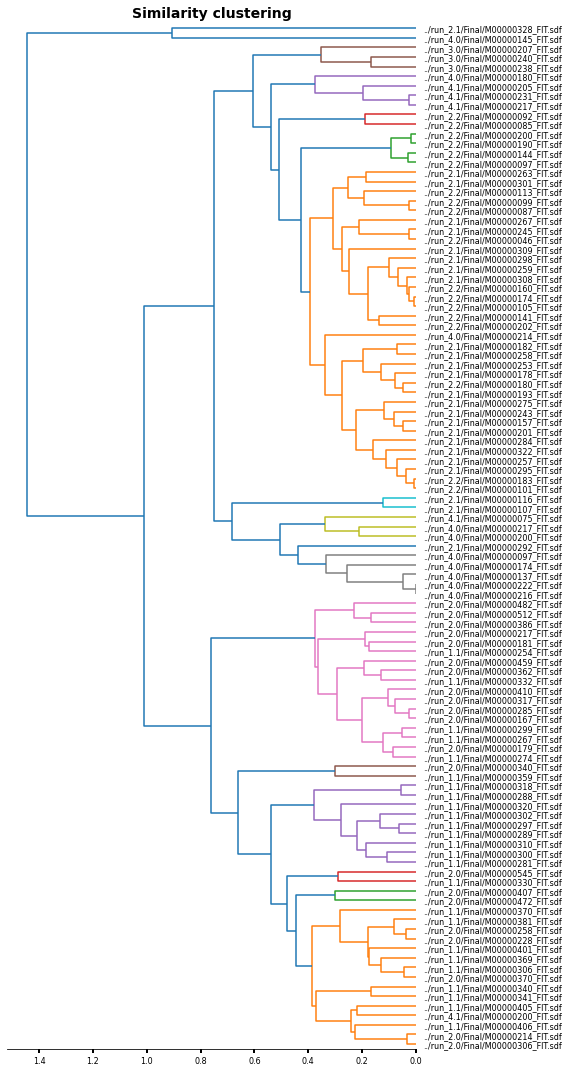

In [7]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

#This decides at which point the dendrogram is cut into clusters
clustering_threshold = 0.4
fig = plt.figure(figsize=(8,15))
ax = fig.add_subplot(111)
o = dendrogram(linked,  
            color_threshold=clustering_threshold,
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Similarity clustering',fontsize=14,weight='bold')
plt.tick_params ('both',width=2,labelsize=8)
plt.tight_layout()
plt.show() 

fig.savefig('dendrogram_complete.pdf')

In [8]:
numClusters=0
oldColor = ''
for c in o['leaves_color_list']:
    #print('color ',c)
    if c is 'C0':
        numClusters = numClusters + 1
        #print('Single-member cluster ',c)
    else:
        if not c is oldColor:
            #print('new color ',c)
            numClusters = numClusters + 1
            oldColor = c
            
print('I count ',numClusters,' clusters from the above dendrogram.')
        

I count  17  clusters from the above dendrogram.


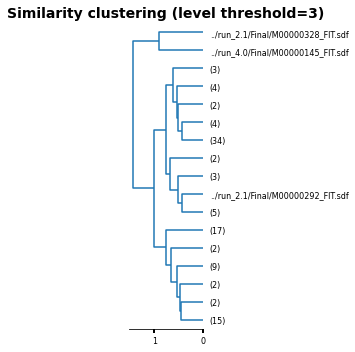

/opt/miniconda3/envs/Ru-C_Design/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
/opt/miniconda3/envs/Ru-C_Design/lib/python3.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.


-> Cluster  0  is a goup  (15)
   Analysis of cluster with  15  molecules
   Fitness Min/Max:  -1.81523   -1.81267
-> Cluster  1  is a goup  (2)
   Analysis of cluster with  2  molecules
   Fitness Min/Max:  -1.81278   -1.81221
-> Cluster  2  is a goup  (2)
   Analysis of cluster with  2  molecules
   Fitness Min/Max:  -1.81329   -1.81277
-> Cluster  3  is a goup  (9)
   Analysis of cluster with  9  molecules
   Fitness Min/Max:  -1.81351   -1.81278
-> Cluster  4  is a goup  (2)
   Analysis of cluster with  2  molecules
   Fitness Min/Max:  -1.8132   -1.81275
-> Cluster  5  is a goup  (17)
   Analysis of cluster with  17  molecules
   Fitness Min/Max:  -1.81359   -1.8123
-> Cluster  6  is a goup  (5)
   Analysis of cluster with  5  molecules
   Fitness Min/Max:  -1.81602   -1.81562
-> Cluster  7  contains a single file:  ../run_2.1/Final/M00000292_FIT.sdf
   Fitness Min/Max:  -1.81465   -1.81465
-> Cluster  8  is a goup  (3)
   Analysis of cluster with  3  molecules
   Fitness Min/Max:

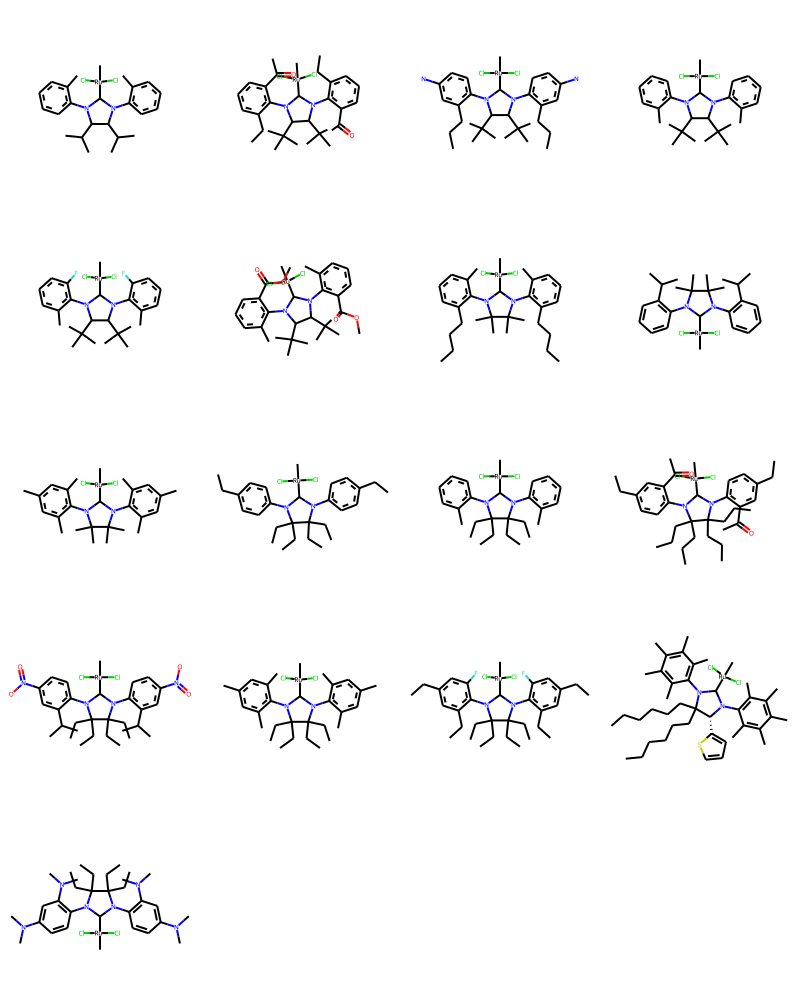

In [9]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import leaves_list

fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(111)
dndr_shallow = dendrogram(linked,
            #WARNING: manually chosen, arbitrary 'p' chosed to reproduce above clustering. In particular,
            # p has to be egual to the number of clusters (i.e., colored clusters + single leaves that keep the C0 color)
            p=numClusters,
            #clustering_threshold not used here because I want to get the innermost nodes
            color_threshold=0,
            truncate_mode='lastp',
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Similarity clustering (level threshold=3)',fontsize=14,weight='bold')
plt.tick_params ('both',width=2,labelsize=8)
plt.tight_layout()
plt.show() 

from rdkit.Chem import MCS
from rdkit.Chem import rdFMCS 
from rdkit.Chem import AllChem

il=-1

leafs = np.flip(leaves_list(linked))

clusters =[]
mcss=[]
mcsMols = []
minFitness = []
maxFitness = []
print('Collecting and analyzing cluster members (starting from bottom part of dendrogram)')
ig=-1
for l in dndr_shallow['ivl']:
    ig=ig+1;
    cluster = []
    if '.sdf' in l:
        print('-> Cluster ',ig,' contains a single file: ',l)
        il=il+1
        mol = candidatesUnderAnalysis[leafs[il]]
        cluster.append(mol)
        clusters.append(cluster)
        mcss.append('none')
        mol2d = mol
        AllChem.Compute2DCoords(mol)
        mcsMols.append(mol)
        minFitness.append(float(mol.GetProp('FITNESS')))
        maxFitness.append(float(mol.GetProp('FITNESS')))
        print('   Fitness Min/Max: ',mol.GetProp('FITNESS'),' ',mol.GetProp('FITNESS'))
    else:
        print('-> Cluster ',ig,' is a goup ',l)
        n = int(str(l).replace('(','').replace(')',''))
        fits = []
        for i in range(il+1,il+n+1):
            il=i
            mol = candidatesUnderAnalysis[leafs[il]]
            cluster.append(mol)
            fits.append(float(mol.GetProp('FITNESS')))
        clusters.append(cluster)
        print('   Analysis of cluster with ',len(cluster),' molecules')
        mcs = MCS.FindMCS(cluster)
        mol = Chem.MolFromSmarts(mcs.smarts)
        #mcs = rdFMCS.FindMCS(cluster)
        #mol = Chem.MolFromSmarts(mcs.smartsString)
        mcss.append(mcs)
        AllChem.Compute2DCoords(mol)
        mcsMols.append(mol)
        minFitness.append(min(fits))
        maxFitness.append(max(fits))
        print('   Fitness Min/Max: ',min(fits),' ',max(fits))

#fileName = 'cluster_'+str(ig)+'.sdf'
#with Chem.SDWriter('fileName') as w:
#    for m in cluster:
#        w.write(m)        
        
from rdkit.Chem import Draw

#for i in range(len(minFitness)):
#    print(str(len(clusters[i]))+': '+str(minFitness[i])+'/'+str(maxFitness[i]))
print('Here are the corresponding Maximum Common Structures for each cluster:')
Draw.MolsToGridImage(mcsMols,molsPerRow=4,subImgSize=(200,200))  

In [10]:
#for i,mcs in enumerate(mcss):
#    print(" -> cluster ",i,': ')
#    print(mcs)

/opt/miniconda3/envs/Ru-C_Design/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
print('Collecting cluster members into SDF files')
clusters =[]
il=-1
leafs = np.flip(leaves_list(linked))
ig=-1
for l in dndr_shallow['ivl']:
    ig=ig+1;
    cluster = []
    if '.sdf' in l:
        print('-> Cluster ',ig,' contains a single file: ',l)
        il=il+1
        mol = candidatesUnderAnalysis[leafs[il]]
        cluster.append(mol)
        clusters.append(cluster)
    else:
        print('-> Cluster ',ig,' is a goup ',l)
        n = int(str(l).replace('(','').replace(')',''))
        for i in range(il+1,il+n+1):
            il=i
            mol = candidatesUnderAnalysis[leafs[il]]
            cluster.append(mol)
        clusters.append(cluster)
    fileName = 'cluster_'+str(ig)+'.sdf'
    print('   Saving cluster to file ',fileName)
    w = Chem.rdmolfiles.SDWriter(fileName)
    for m in cluster:
        w.write(m)
    w.close()

-> Cluster  0  is a goup  (15)
   Saving cluster to file  cluster_0.sdf
-> Cluster  1  is a goup  (2)
   Saving cluster to file  cluster_1.sdf
-> Cluster  2  is a goup  (2)
   Saving cluster to file  cluster_2.sdf
-> Cluster  3  is a goup  (9)
   Saving cluster to file  cluster_3.sdf
-> Cluster  4  is a goup  (2)
   Saving cluster to file  cluster_4.sdf
-> Cluster  5  is a goup  (17)
   Saving cluster to file  cluster_5.sdf
-> Cluster  6  is a goup  (5)
   Saving cluster to file  cluster_6.sdf
-> Cluster  7  contains a single file:  ../run_2.1/Final/M00000292_FIT.sdf
   Saving cluster to file  cluster_7.sdf
-> Cluster  8  is a goup  (3)
   Saving cluster to file  cluster_8.sdf
-> Cluster  9  is a goup  (2)
   Saving cluster to file  cluster_9.sdf
-> Cluster  10  is a goup  (34)
   Saving cluster to file  cluster_10.sdf
-> Cluster  11  is a goup  (4)
   Saving cluster to file  cluster_11.sdf
-> Cluster  12  is a goup  (2)
   Saving cluster to file  cluster_12.sdf
-> Cluster  13  is a go

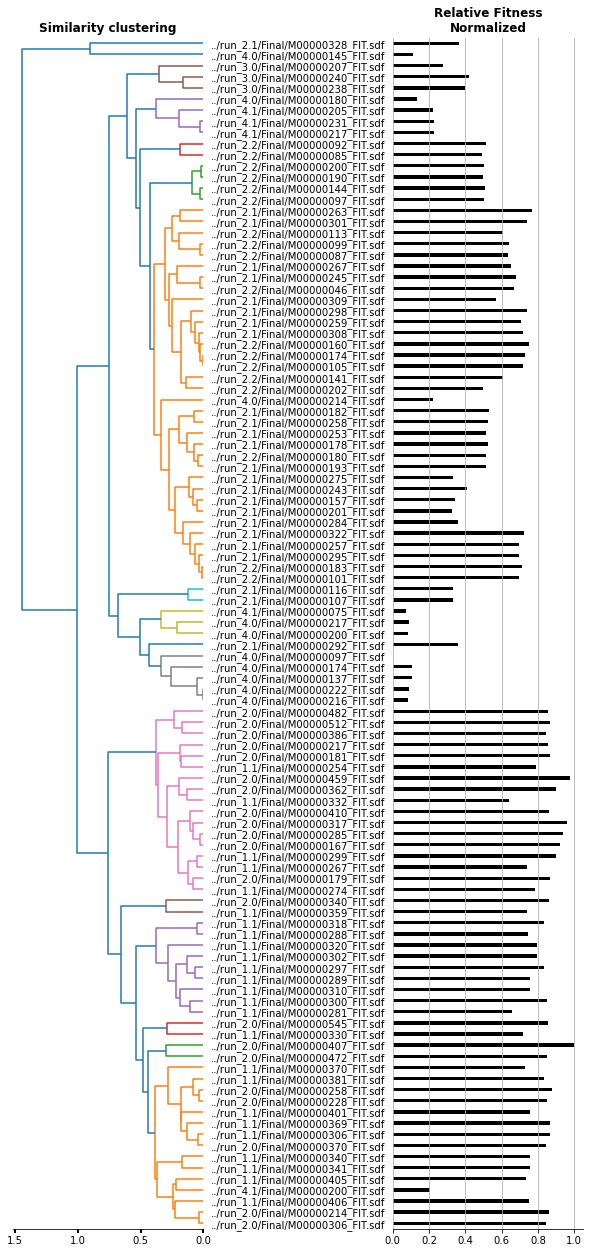

In [12]:
# Making draft of figure for paper's SI
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

fig = plt.figure(figsize=(8,17))
ax1 = fig.add_subplot(121)

# Now, we actually create the dendrogram plot
dndr = dendrogram(linked,  
            color_threshold=clustering_threshold,
            orientation='left',
            distance_sort='descending',
            labels=labelList,
            #leaf_label_func=llf,
            show_leaf_counts=False)

ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.yaxis.set_visible(False)
plt.title('Similarity clustering',fontsize=12,weight='bold')
plt.tick_params ('both',width=2,labelsize=10)


#plt.tight_layout()

# Second plot the fitness-vector
npf = np.array(fitnesses)
normalized_fitness = (npf - np.min(npf)) / (np.max(npf) - np.min(npf))
fitnesses_normalized = normalized_fitness.tolist()

x_f = []
y_f = []
leafs_direct = leaves_list(linked)
for i in range(len(leafs_direct)):
    x_f.append(i)
    y_f.append(fitnesses_normalized[leafs_direct[i]])
    
ax2 = fig.add_subplot(122) 
ax2.grid(which='major', axis='x')
ax2.barh(x_f,y_f,0.3,color='black')
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_ylim([0.5+len(dndr['leaves_color_list'])-1,-0.5])
fig.tight_layout(pad=0)
plt.title('Relative Fitness\nNormalized',fontsize=12,weight='bold')
plt.show()


fig.savefig('dendrogram_complete_and_fitness.pdf')

/opt/miniconda3/envs/Ru-C_Design/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


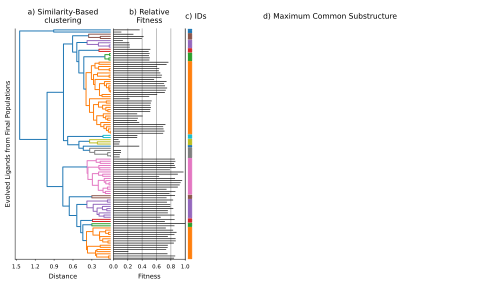

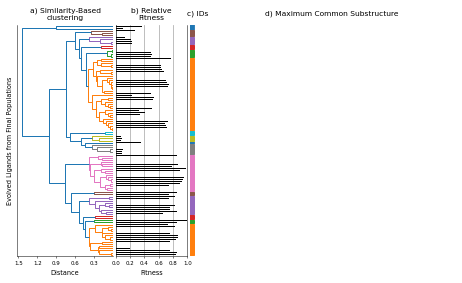

In [13]:
# Making figure for paper
import svgutils.compose as sc
from IPython.display import SVG 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.cluster.hierarchy import dendrogram

# First run but not plot the dendrogram
R = dendrogram(linked,  
            color_threshold=clustering_threshold,
            orientation='left',
            distance_sort='descending',
            show_leaf_counts=False,
            no_plot=True)

temp = {R["leaves"][ii]: 'HH' for ii in range(len(R["leaves"]))}
def llf(xx):
    return ''

titleFontSize=7.5
titleFontStyle='medium'
axisLabelFontSize=6.5
splinesWidth=0.5
ticksSize=1.5

fig = plt.figure(figsize=(7,4)) # 9, 4.5
gs = gridspec.GridSpec(1, 4, width_ratios=[1.2, 0.9, 0.2, 3.1]) 

#ax1 = fig.add_subplot(141)
ax1 = plt.subplot(gs[0])

matplotlib.rcParams['lines.linewidth'] = 01.0

# Now, we actually create the dendrogram plot
dndr = dendrogram(linked,  
            color_threshold=clustering_threshold,
            orientation='left',
            distance_sort='descending',
            labels=labelList,
            #leaf_label_func=llf,
            show_leaf_counts=False)

#ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.yaxis.set_visible(False)
ax1.spines['left'].set_linewidth(splinesWidth)
ax1.spines['top'].set_linewidth(splinesWidth)
ax1.spines['right'].set_linewidth(splinesWidth)
ax1.spines['bottom'].set_linewidth(splinesWidth)
plt.ylabel('Evolved Ligands from Final Populations',fontsize=axisLabelFontSize)
plt.xlabel('Distance',fontsize=axisLabelFontSize)
ax1.set_xticks([0.3, 0.6, 0.9, 1.2, 1.5])
#ax1.set_xticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
ax1.set_yticks([])
plt.title('a) Similarity-Based\nclustering',fontsize=titleFontSize,weight=titleFontStyle)
plt.tick_params('both',width=0.5,length=ticksSize,labelsize=axisLabelFontSize-1)

#plt.tight_layout()

# Second plot the fitness-vector
npf = np.array(fitnesses)
normalized_fitness = (npf - np.min(npf)) / (np.max(npf) - np.min(npf))
fitnesses_normalized = normalized_fitness.tolist()

x_f = []
y_f = []
leafs_direct = leaves_list(linked)
for i in range(len(leafs_direct)):
    x_f.append(i)
    y_f.append(fitnesses_normalized[leafs_direct[i]])
    
#ax2 = fig.add_subplot(142)
ax2 = plt.subplot(gs[1])

ax2.barh(x_f,y_f,0.3,color='black', zorder=10)
#ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(splinesWidth)
ax2.spines['top'].set_linewidth(splinesWidth)
ax2.spines['right'].set_linewidth(splinesWidth)
ax2.spines['bottom'].set_linewidth(splinesWidth)
ax2.yaxis.set_visible(False)
ax2.set_ylim([0.5+len(dndr['leaves_color_list'])-1,-0.5])
ax2.set_xlim([0,1.0])
#ax2.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax2.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#fig.tight_layout(pad=1.0)
plt.subplots_adjust(
    left  = 0.03,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.025,   # the amount of width reserved for blank space between subplots
    hspace = 0.2)  # the amount of height reserved for white space between subplots
plt.tick_params ('both',width=0.5,length=ticksSize,labelsize=axisLabelFontSize-1)
plt.xlabel('Fitness',fontsize=axisLabelFontSize)
ax2.grid(which='major', axis='x', zorder=0)
plt.title('b) Relative\nFitness',fontsize=titleFontSize,weight=titleFontStyle)

# From here we prepare for third plot
blocks = []
block = []
blockOld = []
oldC = dndr['leaves_color_list'][0]
for c in dndr['leaves_color_list']:
    if c == 'C0':
        block = [c]
        blocks.append(blockOld)
        oldC = c
        blockOld = block
    else:
        if c == oldC:
            blockOld.append(c)
        else:
            block = [c]
            blocks.append(blockOld)
            oldC = c
            blockOld = block
blocks.append(blockOld)

# WARNING: manual edit of last block (two single-member clusters have the same color and are therefore perceived as the same cluster, which i wrong)
blocks.pop()
# WARNING: manual addition of two single-membered clusters
blocks.append([oldC])
blocks.append([oldC])
        
showBlock = []
for i, b in enumerate(blocks):
    showBlock.append(True)

# Here we manually decide which blocks to NOT show
#showBlock[5] = False
#showBlock[7] = False

#ax3 = fig.add_subplot(143)
ax3 = plt.subplot(gs[2])

ax3.set_ylim([-0.5,0.5+(len(dndr['leaves_color_list'])-1)])
lw=0.15
offSet=0.25
endOfLast = 0
for block, showIt in zip(blocks,showBlock):
    if showIt:
        ax3.arrow(0.02, endOfLast-offSet, 0.0, len(block)-1+2*offSet, color=block[0], width=lw,
                 head_width=0, head_length=0)
    endOfLast = endOfLast + len(block)

ax3.set_xlim([0,0.4])
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.set_title('c) IDs',loc='center',fontsize=titleFontSize, weight=titleFontStyle, y=1.018)

ax4 = plt.subplot(gs[3])
ax4.set_title('d) Maximum Common Substructure',loc='center',fontsize=titleFontSize, weight=titleFontStyle, y=1.018)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.xaxis.set_visible(False)
ax4.yaxis.set_visible(False)

# WARNING: manual insertion of arrows from cluster to MCS
labelXcoord=0.06
def addArrowx():
    ax3.annotate('A', xy=(0.7, 78),
                 xycoords='data',
                 xytext=(labelXcoord, 81.5),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '-|>',
                                 color='C0',
                                 lw=0.8,
                                 ls='-'),
                 horizontalalignment='center', 
                 verticalalignment='center',
                 fontsize=8)
    ax3.annotate('B', xy=(0.3, 69),
                 xycoords='data',
                 xytext=(labelXcoord, 77),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '-|>',
                                 color='C4',
                                 lw=0.8,
                                 ls='-'),
                 horizontalalignment='center', 
                 verticalalignment='center',
                 fontsize=8)
    ax3.annotate('C', xy=(0.75, 49.5),
                 xycoords='data',
                 xytext=(labelXcoord, 49.5),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '-|>',
                                 color='C3',
                                 lw=0.8,
                                 ls='-'),
                 horizontalalignment='center', 
                 verticalalignment='center',
                 fontsize=8)
    ax3.annotate('D', xy=(0.15, 24.5),
                 xycoords='data',
                 xytext=(labelXcoord, 17.5),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '-|>',
                                 color='C2',
                                 lw=0.8,
                                 ls='-'),
                 horizontalalignment='center', 
                 verticalalignment='center',
                 fontsize=8)
    ax3.annotate('E', xy=(0.4, 15),
                 xycoords='data',
                 xytext=(labelXcoord, 9.5),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '-|>',
                                 color='C0',
                                 lw=0.8,
                                 ls='-'),
                 horizontalalignment='center', 
                 verticalalignment='center',
                 fontsize=8)
    ax3.annotate('F', xy=(0.85, 3),
                 xycoords='data',
                 xytext=(labelXcoord, 4.5),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '-|>',
                                 color='C1',
                                 lw=0.8,
                                 ls='-'),
                 horizontalalignment='center', 
                 verticalalignment='center',
                 fontsize=8)

#plt.show()
#fig.savefig('dendrogram_and_fitness.pdf')

plt.savefig("dendrogram_and_fitness.svg")
SVG("dendrogram_and_fitness.svg")

# Use this to combine this SVG with the chemical structures
#sc.Figure("648pt", "324pt",
#    sc.Panel(sc.SVG("dendrogram_and_fitness.svg")),
#    sc.Panel(sc.SVG("mcs_0.svg")).scale(0.39).move(370,259),
#    sc.Panel(sc.SVG("mcs_1.svg")).scale(0.39).move(520,245),
#    sc.Panel(sc.SVG("mcs_2.svg")).scale(0.39).move(520,170),
#    sc.Panel(sc.SVG("mcs_3.svg")).scale(0.39).move(405,170),
#    sc.Panel(sc.SVG("mcs_4.svg")).scale(0.39).move(350,170),
#    sc.Panel(sc.SVG("mcs_5.svg")).scale(0.39).move(515,30),
#    sc.Panel(sc.SVG("mcs_10.svg")).scale(0.39).move(350,30)
#    ).save("dendrogram_with_fitness_and_MCS.svg")
#SVG('dendrogram_with_fitness_and_MCS.svg')


Since the chemical drawign are ugly, I make them by hand in ChemDraw and save them as *.svg. 

Finally, the final figure for the paper is assembled with Inkscape by merging these files:
* dendrogram_and_fitness.svg
* mcs_0.svg
* mcs_1.svg
* mcs_10.svg
* mcs_2.svg
* mcs_3.svg
* mcs_4.svg
* mcs_5.svg

The overal result is saved as `dendrogram_and_fitness_and_chemdraws.svg`

In [14]:
# What is the difference between these two?
#Answer: a pair of methyl groups!

files = ["../run_4.0/Final/M00000216_FIT.sdf", "../run_4.0/Final/M00000222_FIT.sdf"]
for file in files:
    print('File: ',file)
    supplier = Chem.SDMolSupplier(file);
    for mol in supplier:
        mol.SetProp('Pathname',fitFile)
        inchi = Chem.inchi.MolToInchi(mol)
        inchikey = Chem.inchi.InchiToInchiKey(inchi)
        print('  InChI: ',inchi)
        print('  InChIKey: ',inchikey)

File:  ../run_4.0/Final/M00000216_FIT.sdf
  InChI:  InChI=1S/C37H59N2.CH3.2ClH.Ru/c1-11-15-19-30-23-28(5)34(32(25-30)21-17-13-3)38-27-39(37(9,10)36(38,7)8)35-29(6)24-31(20-16-12-2)26-33(35)22-18-14-4;;;;/h23-27H,11-22H2,1-10H3;1H3;2*1H;/q;;;;+2/p-2
  InChIKey:  JTJHIHVRWNGYHY-UHFFFAOYSA-L
File:  ../run_4.0/Final/M00000222_FIT.sdf
  InChI:  InChI=1S/C35H55N2.CH3.2ClH.Ru/c1-11-15-19-30-23-28(17-13-3)21-26(5)32(30)36-25-37(35(9,10)34(36,7)8)33-27(6)22-29(18-14-4)24-31(33)20-16-12-2;;;;/h21-25H,11-20H2,1-10H3;1H3;2*1H;/q;;;;+2/p-2
  InChIKey:  IONUOSLAONSHQT-UHFFFAOYSA-L


In [15]:
import rdkit
print(rdkit.__version__)


2020.09.1
